Animal Image Classification

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d 'alessiocorrado99/animals10'

 99% 579M/586M [00:06<00:00, 92.4MB/s]
100% 586M/586M [00:07<00:00, 86.0MB/s]


In [6]:
!cp animals10.zip /tmp

In [7]:
import os
import zipfile
local_zip = '/tmp/animals10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

translate =
cane: dog,
cavallo: horse,
elefante: elephant,
farfalla: butterfly,
gallina: chicken,
gatto: cat,
mucca: cow,
pecora: sheep,
ragno: spider,
scoiattolo: squirrel

In [8]:
os.listdir('/tmp/raw-img')

['mucca',
 'farfalla',
 'cane',
 'gatto',
 'cavallo',
 'scoiattolo',
 'elefante',
 'pecora',
 'ragno',
 'gallina']

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('/tmp/raw-img')
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   fill_mode = 'nearest',
                                   validation_split=0.2)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet152V2

base_model = ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

234545216/234545216 [==============================] - 1s 0us/step


In [12]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nreached")
      self.model.stop_training = True
callbacks = Callback()

In [14]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=30,
    verbose=2,
    callbacks=[callbacks])

Epoch 1/30
655/655 - 212s - loss: 0.5692 - accuracy: 0.8251 - val_loss: 0.3365 - val_accuracy: 0.8903 - 212s/epoch - 324ms/step
Epoch 2/30
655/655 - 195s - loss: 0.4337 - accuracy: 0.8660 - val_loss: 0.3245 - val_accuracy: 0.8951 - 195s/epoch - 297ms/step
Epoch 3/30
655/655 - 191s - loss: 0.3746 - accuracy: 0.8789 - val_loss: 0.3109 - val_accuracy: 0.9037 - 191s/epoch - 292ms/step
Epoch 4/30
655/655 - 189s - loss: 0.3525 - accuracy: 0.8883 - val_loss: 0.2947 - val_accuracy: 0.9060 - 189s/epoch - 289ms/step
Epoch 5/30
655/655 - 190s - loss: 0.3423 - accuracy: 0.8916 - val_loss: 0.2764 - val_accuracy: 0.9090 - 190s/epoch - 290ms/step
Epoch 6/30
655/655 - 190s - loss: 0.3323 - accuracy: 0.8959 - val_loss: 0.2869 - val_accuracy: 0.9063 - 190s/epoch - 291ms/step
Epoch 7/30
655/655 - 190s - loss: 0.3145 - accuracy: 0.8995 - val_loss: 0.2894 - val_accuracy: 0.9073 - 190s/epoch - 290ms/step
Epoch 8/30
655/655 - 190s - loss: 0.3103 - accuracy: 0.9029 - val_loss: 0.2775 - val_accuracy: 0.9111 - 

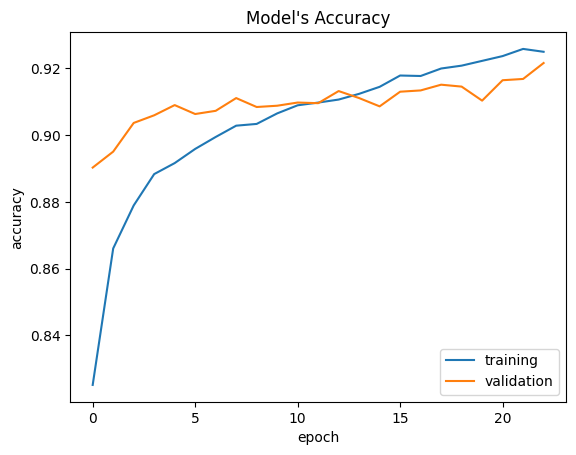

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model's Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

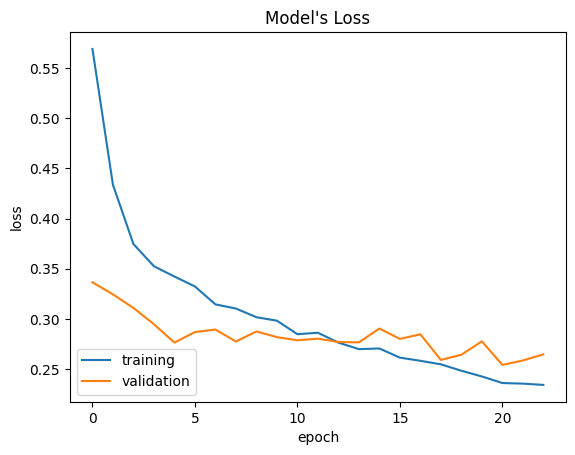

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower left')
plt.show()

In [17]:
import pathlib
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('animals.tflite')
tflite_model_file.write_bytes(tflite_model)

237542652